In [2]:
import os, shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms.v2.functional as F_v2
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from Methods.iGPA.model import iGPA
from Methods.BYOL.model import BYOL
from Methods.AE.model import AE
from Methods.MAE.model import MAE
from Methods.GPAViT.model import GPAViT
from Methods.GPAMAE.model import GPAMAE
from Methods.VAE.model import VAE
from Methods.Supervised.model import Supervised

# from Examples.ModelNet10.evals import linear_probing, eval_representations
from Examples.ModelNet10.dataset import ModelNet10, ModelNet10Simple
from Utils.functional import get_optimiser
from Utils.train import train
from Utils.evals import linear_probing, eval_representations

In [13]:
def test_fn(**kwargs):
   print(type(kwargs)) 
   print(kwargs)
test_fn(a=1, b=2, c=3)

<class 'dict'>
{'a': 1, 'b': 2, 'c': 3}


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True
device

'cuda'

In [3]:
root = '../Datasets/'
res = 128
train_set = ModelNet10(root, 'train', device=torch.device('cpu'), res=res)
train_set.data.shape
train_set, val_set = train_set.split_set(0.8)

Building dataset...


  0%|          | 0/10 [00:10<?, ?it/s]


KeyboardInterrupt: 

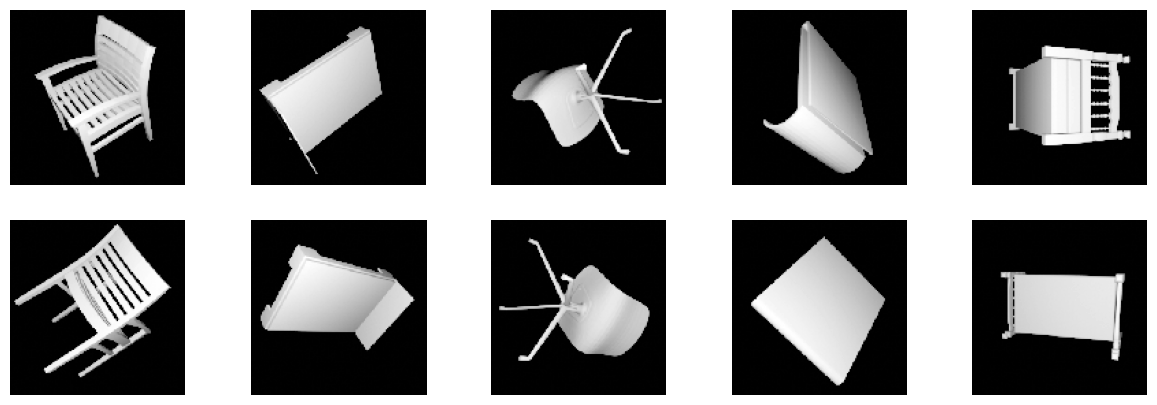

Max value: tensor(221, dtype=torch.uint8)
Min value: tensor(0, dtype=torch.uint8)


In [4]:
fig, axes = plt.subplots(2, 5, figsize=(15,5))
for i, ax in enumerate(axes[0]):
    (img1, rot1, lab1), _ = train_set[i]
    ax.imshow(img1.squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    _, (img2, rot2, lab2) = train_set[i]
    ax.imshow(img2.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.data.max())
print('Min value:', train_set.data.min())

In [5]:
cfgs = [
    {
        'name': 'iGPA_quat2',
        'model': iGPA,
        'save': True,
        'lr': 3e-4,
        'epochs': 1000,
        'warmup': 10,
    },
    {
        'name': 'iGPA_quat2',
        'model': iGPA,
        'save': True,
        'lr': 3e-5,
        'epochs': 1000,
        'warmup': 0,
    },
    {
        'name': 'iGPA_quat2',
        'model': iGPA,
        'save': True,
        'lr': 1e-5,
        'epochs': 250,
        'warmup': 0,
    },
]

for cfg in cfgs:

    Model = cfg['model']
    backbone = 'resnet18'
    experiment_name = cfg['name']
    # experiment = 'mnist_byol'
    experiment='modelnet10'
    # log_dir = None
    log_dir = f'Examples/ModelNet10/out/logs/{experiment}/{experiment_name}/'
    save_dir = None
    if cfg['save']:
        save_dir = f'Examples/ModelNet10/out/models/{experiment}/{experiment_name}.pth'
    if Model == VAE:
        model = Model(1, 256, backbone=backbone, decoder_out_size=res).to(device)
    elif Model == AE or Model == BYOL or Model == MAE:
        model = Model(1, backbone=backbone, decoder_out_size=res).to(device)
    else:
        model = Model(1, 4, backbone=backbone, decoder_out_size=res).to(device)

    optimiser = get_optimiser(
        model, 
        'AdamW', 
        # lr=3e-4, 
        lr=cfg['lr'],
        # lr=1e-5,
        wd=0.004, 
        exclude_bias=True,
        exclude_bn=True,
    )

    to_train = True
    if save_dir is not None:
        try:
            sd = torch.load(save_dir)
           # change keys "project" to "transition"
            for key in list(sd.keys()):
                if 'project' in key:
                    sd[key.replace('project', 'transition')] = sd.pop(key)
            model.load_state_dict(sd)
            # to_train = False
            print('Model loaded successfully')
        except FileNotFoundError:
            pass
            print('Model not found, training new model')
    if to_train:
        writer = None
        if log_dir is not None:
            # remove reduction if exists
            if os.path.exists(log_dir + 'encoder/reduction.csv'):
                os.remove(log_dir + 'encoder/reduction.csv')
            if os.path.exists(log_dir + 'classifier/reduction.csv'):
                os.remove(log_dir + 'classifier/reduction.csv')

            run_no = 1
            while os.path.exists(log_dir + 'encoder/' + f'run_{run_no}'):
                run_no += 1
            writer = SummaryWriter(log_dir + 'encoder/' + f'run_{run_no}')
        
        if isinstance(model, iGPA):
            train_set.transform = transforms.Compose([
            ])
            train(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=cfg['epochs'], 
                batch_size=128,
                dataset='modelnet10',
                has_teacher=True,
                aug_mode='sample',
                augment=None,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
                res=res,
                warmup=cfg['warmup'],
                decay_lr=False,
            )
        if isinstance(model, BYOL):
            train_set.transform = transforms.Compose([
            ])
            optimiser = get_optimiser(
                model, 
                'AdamW', 
                lr=3e-5, 
                wd=0.004, 
                exclude_bias=True,
                exclude_bn=True,
            )
            train(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250, 
                batch_size=128,
                dataset='modelnet10',
                has_teacher=True,
                aug_mode='sample',
                augment=None,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
                res=res
            )
        if isinstance(model, AE):
            train_set.transform = transforms.Compose([
                # transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            ])
            train(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=cfg['epochs'],
                batch_size=128,
                dataset='modelnet10',
                writer=writer,
                save_dir=save_dir,
                save_every=5,
                res=res,
                decay_lr=False,
            )
        if isinstance(model, VAE):
            train_set.transform = transforms.Compose([
                transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            ])
            train(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250, 
                batch_size=128,
                dataset='modelnet10',
                writer=writer,
                save_dir=save_dir,
                save_every=5,
                res=res,
            )
        if isinstance(model, MAE):
            train_set.transform = transforms.Compose([
                transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            ])
            train(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250, 
                batch_size=256,
                dataset='modelnet10',
                writer=writer,
                save_dir=save_dir,
                save_every=5,
                res=res,
            )
        if isinstance(model, Supervised):
            train_set.transform = transforms.Compose([
                transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            ])
            train(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250, 
                batch_size=128,
                dataset='modelnet10',
                writer=writer,
                save_dir=save_dir,
                save_every=5,
                res=res,
            )
        
        print(f'Finished training')
        if save_dir is not None:
            print('Run cell again to load best (val_acc) model.')

        # Evaluate inter-neuron correlations
        rep_metrics = eval_representations(model, root=root, dataset='modelnet10', flatten=False, res=128)
        if writer is not None:
            writer.add_scalar('Encoder/test_feature_corr', rep_metrics['corr'])
            writer.add_scalar('Encoder/test_feature_std', rep_metrics['std'])

    # # linear probing
    # for n in [1, 10, 100, 1000]:
    #     dest = f'Examples/ModelNet10/out/logs/n{n}-{experiment}/{experiment_name}/'
    #     if log_dir is not None:
    #         run_no = 1
    #         while os.path.exists(dest + 'classifier/' + f'run_{run_no}'):
    #             run_no += 1
    #         writer = SummaryWriter(dest + f'classifier/run_{run_no}')
    #     linear_probing(model, 'modelnet10', root, n, writer, flatten=False, test=True, res=res)

    # # Semi-supervised learning eval
    # for n in [1, 10, 100, 1000]:
    #     dest = f'Examples/MNIST/out/logs/n{n}-{experiment}/{experiment_name}/'
    #     if log_dir is not None:
    #         writer = SummaryWriter(dest + f'classifier/run_{run_no}')
    #     mnist_linear_eval(model, n, writer, flatten=False, test=True, finetune=True)

Model not found, training new model
Loading data...
Loading data...


Epoch [0/1000]:   0%|          | 0/25 [00:00<?, ?it/s]c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Loading data...
Finished training
Run cell again to load best (val_acc) model.
Loading data...
Model loaded successfully
Loading data...
Loading data...


Loading data...
Finished training
Run cell again to load best (val_acc) model.
Loading data...
Model loaded successfully
Loading data...
Loading data...


KeyboardInterrupt: 

In [7]:
x = train_set.data[0, 0, :, :].float() / 255.0
nonzero_std = torch.std(x[x != 0])
print(f"Standard deviation of nonzero values: {nonzero_std.item()}")

Standard deviation of nonzero values: 0.2949479818344116


tensor([[[[2.9032e-05]]],


        [[[3.2959e-05]]],


        [[[2.5958e-05]]],


        [[[3.0127e-05]]],


        [[[3.0550e-05]]]], device='cuda:0')


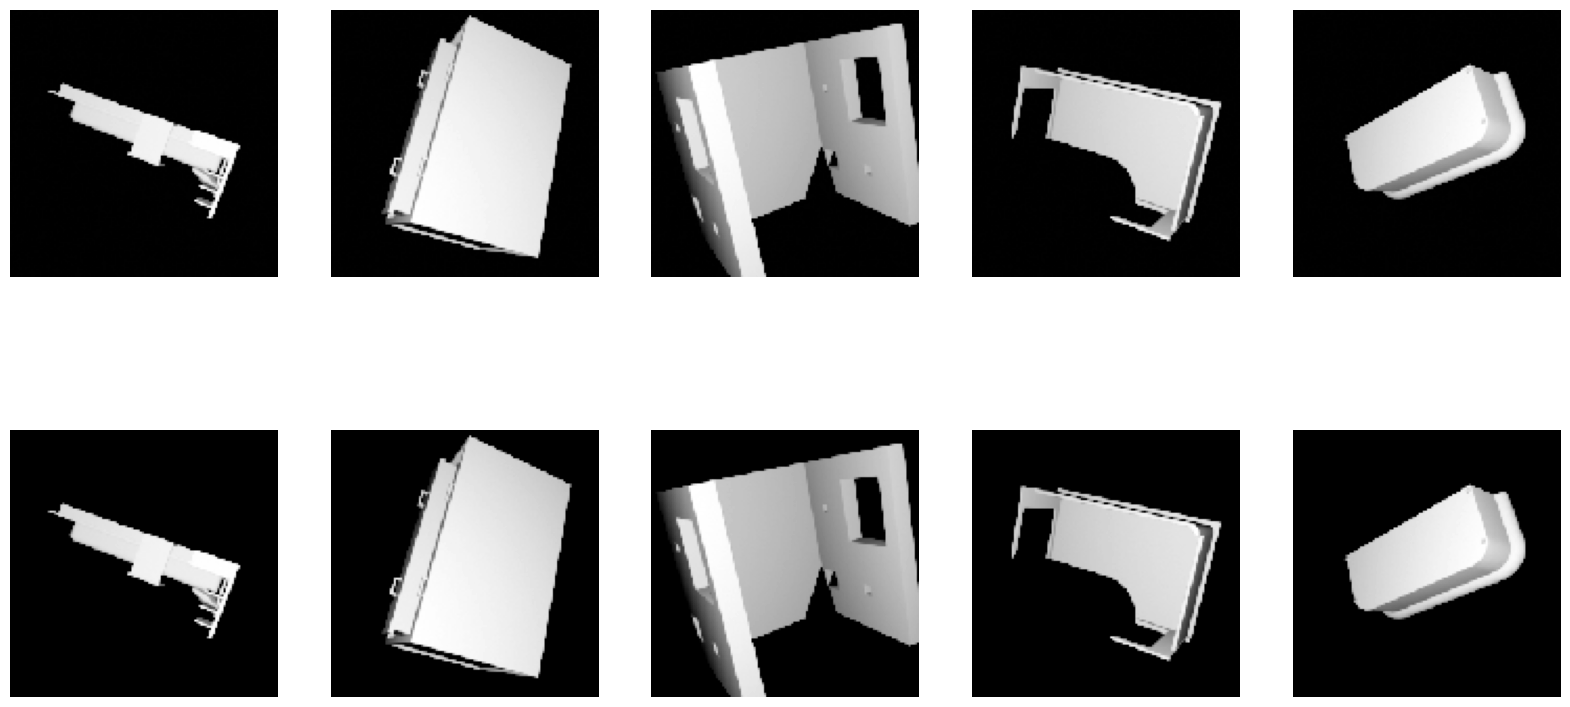

In [7]:
x = train_set.data[0:5, 0, :, :].to(device).float() / 255.0

def increase_contrast(x:torch.Tensor, factor=1.2):
    num_nonzero = torch.count_nonzero(x, (1, 2, 3))
    means = (x.sum(dim=(1, 2, 3)) / num_nonzero).unsqueeze(1).unsqueeze(2).unsqueeze(3)
    stds = (x.std(dim=(1, 2, 3)) / num_nonzero).unsqueeze(1).unsqueeze(2).unsqueeze(3)
    print(stds)
    x = x - means
    x = x * factor
    x = x + means
    x = torch.clamp(x, 0, 1)
    return x
import matplotlib.pyplot as plt

x_contrast = increase_contrast(x)

# Original images
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(5):
    axs[0, i].imshow(x[i, 0, :, :].cpu().detach().numpy(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(x_contrast[i, 0, :, :].cpu().detach().numpy(), cmap='gray')
    axs[1, i].axis('off')


torch.Size([10, 1, 128, 128])
mse: 0.03895913064479828


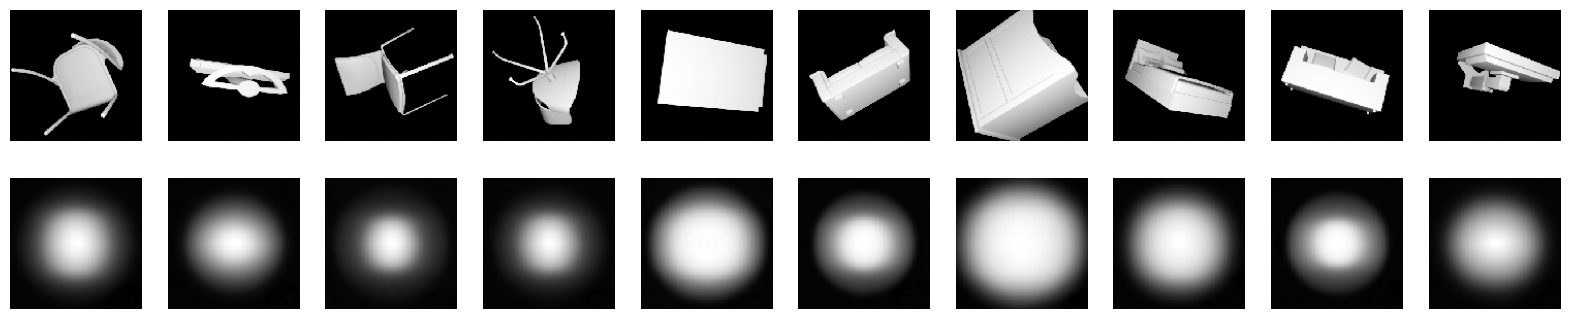

In [6]:
# model_name = 'iGPA_quat'
# model = iGPA(1, 4, backbone='resnet18', decoder_out_size=res)
# model.load_state_dict(torch.load(f'Examples/ModelNet10/out/models/modelnet10/{model_name}.pth'))
# model.to(device)

x = train_set.data[10:20, 0, :, :].to(device).float() / 255.0
print(x.shape)
x_hat = model.predict(x, stop_at=0)
mse = F.mse_loss(x_hat, x)
print(f'mse: {mse}')
import matplotlib.pyplot as plt

# Plotting the original images and their reconstructions
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(x[i, 0, :, :].cpu().detach().numpy(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(x_hat[i, 0, :, :].cpu().detach().numpy(), cmap='gray')
    axs[1, i].axis('off')
plt.show()

mse: 0.03919355198740959


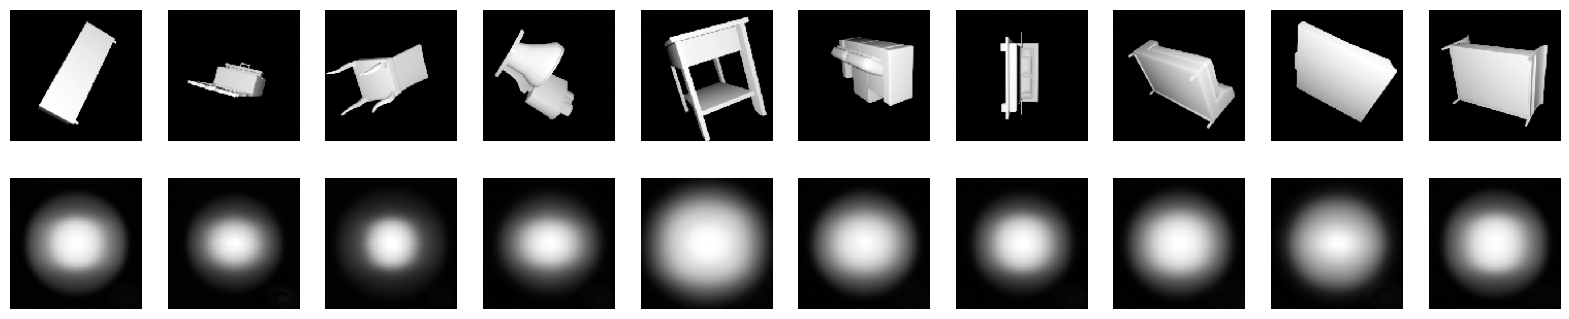

In [10]:
from Utils.functional import quaternion_delta

model_name = 'iGPA_quat2'
model = iGPA(1, 3, backbone='resnet18', decoder_out_size=res)
model.load_state_dict(torch.load(f'Examples/ModelNet10/out/models/modelnet10/{model_name}.pth'))
model.to(device)

dataloader = DataLoader(train_set, batch_size=10, shuffle=True)
i, data = next(enumerate(dataloader))
(images1, rot1, _), (images2, rot2, _) = data
action = quaternion_delta(rot1, rot2)
# action = (rot2 - rot1) / 360.0
pred = model.predict(images1.to(device), action.to(device), stop_at=0)

mse = F.mse_loss(pred, images2.to(device))
print(f'mse: {mse}')

# Plotting the original images and their reconstructions
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(images2[i,0].cpu().detach().numpy(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(pred[i,0].cpu().detach().numpy(), cmap='gray')
    axs[1, i].axis('off')
plt.show()

In [ ]:
class DecBlock(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features

class Decoder128(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(num_features, 256, 8, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.Conv2d(64, 1, 3, 1, 1),
        )

    def forward(self, z):
        z = z.view(-1, self.num_features, 1, 1)
        return self.decoder(z)
    
dec = Decoder128(256)
x = torch.randn(16, 256)
dec(x).shape

torch.Size([16, 1, 128, 128])

In [7]:
# Evaluate inter-neuron correlations
rep_metrics = eval_representations(model, root=root, dataset='modelnet10', flatten=False, res=128)
if writer is not None:
    writer.add_scalar('Encoder/test_feature_corr', rep_metrics['corr'])
    writer.add_scalar('Encoder/test_feature_std', rep_metrics['std'])

Loading data...


In [5]:
model = VAE(1, 256, backbone='resnet18', decoder_out_size=res).to(device)
x = torch.randn(128, 1, 128, 128).to(device)
model.train_step(x, None, None, None, 10)

img1.shape: torch.Size([128, 1, 128, 128])
h.shape: torch.Size([128, 512])
mu.shape: torch.Size([128, 256])
logVar.shape: torch.Size([128, 256])
z.shape: torch.Size([128, 256])
h.shape: torch.Size([128, 512])
x_hat.shape: torch.Size([256, 1, 128, 128])
x_hat.shape: torch.Size([256, 1, 128, 128])


ValueError: Target size (torch.Size([128, 1, 128, 128])) must be the same as input size (torch.Size([256, 1, 128, 128]))

In [ ]:

# linear probing
for n in [1, 10, 100, 1000]:
    dest = f'Examples/MNIST/out/logs/n{n}-{experiment}/{experiment_name}/'
    if log_dir is not None:
        writer = SummaryWriter(dest + f'classifier/run_{run_no}')
    linear_probing(model, root, n, writer, flatten=False, test=True, res=res)

TypeError: '>' not supported between instances of 'int' and 'SummaryWriter'

In [ ]:

z = torch.randn(1, 256)
model = Decoder128(256)
model(z).shape

torch.Size([1, 1, 128, 128])

In [ ]:
from Examples.ModelNet10.dataset import ModelNet10Simple

ss_train_dataset = ModelNet10Simple(root=root, split='train', n=10, transform=None, device=device)
ss_val_dataset = ModelNet10Simple(root=root, split='val', n=10, transform=None, device=device)
ss_train_loader = DataLoader(ss_train_dataset, batch_size=10, shuffle=True)
ss_val_loader = DataLoader(ss_val_dataset, batch_size=1000, shuffle=False)

Loading data...
Loading data...


In [ ]:
# for x, y in ss_train_loader:
#     print(x.shape, y.shape)
ss_train_dataset[0]

(tensor([[[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
          [0.0039, 0.0000, 0.0039,  ..., 0.0039, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0039, 0.0039]]],
        device='cuda:0'),
 tensor([ 7.9319, -5.6256, -4.6848], device='cuda:0'),
 tensor(0, device='cuda:0'))